# Task 1 : Set up colab gpu runtime environment

In [82]:
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/albumentations-team/albumentations to /tmp/pip-req-build-n9fyyzsx
  Running command git clone --filter=blob:none --quiet https://github.com/albumentations-team/albumentations /tmp/pip-req-build-n9fyyzsx
  Resolved https://github.com/albumentations-team/albumentations to commit 1eceb794ccbf52a02b09e630833f61366bef1149
  Preparing metadata (setup.py) ... done
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Download Dataset

original author of the dataset :
https://github.com/VikramShenoy97/Human-Segmentation-Dataset


In [83]:
!git clone https://github.com/parth1620/Human-Segmentation-Dataset-master.git

fatal: destination path 'Human-Segmentation-Dataset-master' already exists and is not an empty directory.


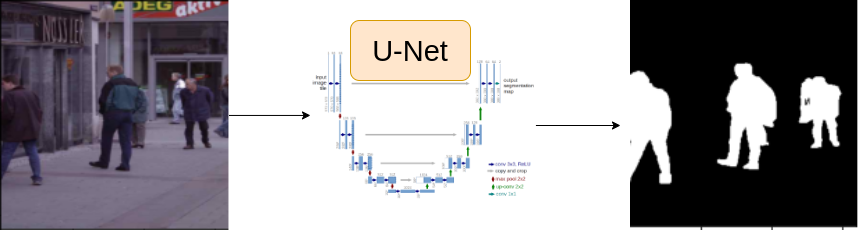

# Some Common Imports

In [84]:
import sys
sys.path.append('/content/Human-Segmentation-Dataset-master')

In [85]:
import torch 
import cv2

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 

from sklearn.model_selection import train_test_split
from tqdm import tqdm

import helper

# Task : 2 Setup Configurations

In [86]:
CSV_FILE = '/content/Human-Segmentation-Dataset-master/train.csv'
DATA_DIR = '/content/'

DEVICE = 'cuda'

EPOCHS = 25
LR = 0.003
IMAGE_SIZE = 320

ENCODER = 'resnet18'#'timm-efficientnet-b0'
WEIGHTS = 'imagenet'

In [87]:
df = pd.read_csv(CSV_FILE)
df.head()

,masks,images
0,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
1,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
2,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
3,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
4,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...


In [88]:
index = 33
row = df.iloc[index]

image_path = row.images
image = cv2.imread(image_path)
image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB) # BGR to RGB Conversion

mask_path = row.masks
mask = cv2.imread(mask_path)
mask = cv2.cvtColor(mask,cv2.COLOR_BGR2GRAY) #BGR to Gray Conversion

(640, 480, 3)
(577, 433)


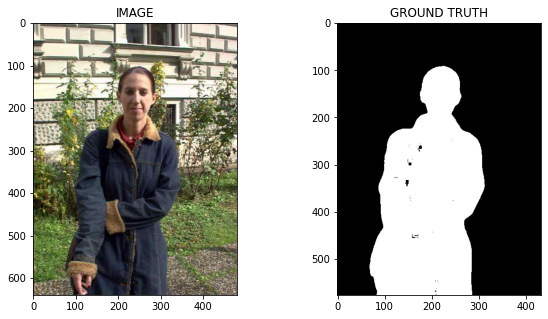

In [89]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
        
ax1.set_title('IMAGE')
ax1.imshow(image)

ax2.set_title('GROUND TRUTH')
ax2.imshow(mask,cmap = 'gray')

print(np.shape(image))
print(np.shape(mask))

In [90]:
train_df,test_df = train_test_split(df,test_size=0.2,random_state=42)

# Task 3 : Augmentation Functions

albumentation documentation : https://albumentations.ai/docs/

In [91]:
import albumentations as A

In [92]:
def get_train_augs():
  return A.Compose(
      [
          A.Resize(IMAGE_SIZE,IMAGE_SIZE),
          A.HorizontalFlip(p=0.5),
          A.VerticalFlip(p=0.5),
      ], is_check_shapes=False
  )

def get_test_augs():
  return A.Compose(
      [
          A.Resize(IMAGE_SIZE,IMAGE_SIZE),
      ], is_check_shapes=False
  )

# Task 4 : Create Custom Dataset 

In [93]:
from torch.utils.data import Dataset

In [94]:
class SegmentationDataset(Dataset):
  def __init__(self,df,augmentations):

    self.df = df
    self.augmentations = augmentations


  def __len__(self):
    return len(self.df)

  def __getitem__(self,idx):
    row = self.df.iloc[idx]

    image_path = row.images
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB) # BGR to RGB Conversion

    mask_path = row.masks
    mask = cv2.imread(mask_path,cv2.IMREAD_GRAYSCALE)
    # mask = cv2.cvtColor(mask,cv2.COLOR_BGR2GRAY) #BGR to Gray Conversion
    mask = np.expand_dims(mask,axis=-1) # To kadd channel axis

    if self.augmentations:
      data = self.augmentations(image=image,mask=mask)
      image = data['image']
      mask = data['mask']

    ### For Torch (h,w,c) --> (c,h,w)

    image = np.transpose(image,(2,0,1)).astype(np.float32)  # start with 32 bit images
    mask = np.transpose(mask,(2,0,1)).astype(np.float32)  # start with 32 bit images

    image = torch.Tensor(image) /255.0
    mask = torch.round(torch.Tensor(mask) /255.0)

    return image,mask


In [95]:
trainset = SegmentationDataset(train_df,get_train_augs())
validset = SegmentationDataset(test_df,get_test_augs())

In [96]:
print(f"Size of Trainset : {len(trainset)}")
print(f"Size of Validset : {len(validset)}")

Size of Trainset : 232
Size of Validset : 58


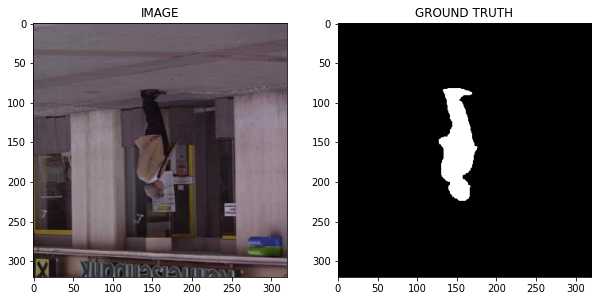

In [97]:
idx = 5
image, mask = trainset[idx]
helper.show_image(image,mask)

# Task 5 : Load dataset into batches

In [98]:
from torch.utils.data import DataLoader

In [99]:
trainloader = DataLoader(trainset,batch_size=16, shuffle=True)
validloader = DataLoader(validset,batch_size=16)

In [100]:
print(f"Total Num of Batches in TrainLoader : {len(trainloader)}")
print(f"Total Num of Batches in ValidLoader : {len(validloader)}")

Total Num of Batches in TrainLoader : 15
Total Num of Batches in ValidLoader : 4


In [101]:
for image,mask in trainloader:
    break

print(f"Tensor Shape for image : {image.shape}")
print(f"Tensor Shape for mask : {mask.shape}")

Tensor Shape for image : torch.Size([16, 3, 320, 320])
Tensor Shape for mask : torch.Size([16, 1, 320, 320])


# Task 6 : Create Segmentation Model

segmentation_models_pytorch documentation : https://smp.readthedocs.io/en/latest/

In [102]:
from torch import nn
import segmentation_models_pytorch as smp

In [103]:
class SegmentationModel(nn.Module):
  def __init__(self):
    super(SegmentationModel,self).__init__()

    self.arc = smp.Unet(
        encoder_name = ENCODER,  #ENCODER = 'timm-efficientnet-b0'
        encoder_weights = WEIGHTS, #WEIGHTS = 'imagenet'
        in_channels = 3,
        classes = 1,
        activation = None  # Output wil be logits
    )

  def forward(self,images,masks=None):

      logits = self.arc(images)

      if masks != None :
        loss1 = smp.losses.DiceLoss(mode='binary')(logits,masks)
        loss2 = nn.BCEWithLogitsLoss()(logits,masks)
        return logits, loss1+loss2
      else:
        return logits

In [104]:
model = SegmentationModel()
model.to(DEVICE);

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

# Task 7 : Create Train and Validation Function 

In [105]:
def train_function(data_loader,model,optimizer):
  model.train()
  total_loss = 0.0
  for images,masks in data_loader:
    images = images.to(DEVICE)
    masks = masks.to(DEVICE)

    optimizer.zero_grad()

    logits,loss = model(images,masks)

    loss.backward()
    optimizer.step()

    total_loss = total_loss + loss.item()

  return total_loss/ len(data_loader)

def eval_function(data_loader,model,optimizer):
  model.eval()
  total_loss = 0.0
  with torch.no_grad():
    for images,masks in data_loader:
      images = images.to(DEVICE)
      masks = masks.to(DEVICE)
  
      logits,loss = model(images,masks)

      total_loss = total_loss + loss.item()

  return total_loss/ len(data_loader)

# Task 8 : Train Model

In [106]:
optimizer = torch.optim.Adam(model.parameters(),lr=LR)
best_valid_loss = np.Inf

for i in range(EPOCHS):
  train_loss = train_function(trainloader,model,optimizer)
  valid_loss = eval_function(validloader,model,optimizer)

  if valid_loss < best_valid_loss:
    best_valid_loss = valid_loss
    torch.save(model.state_dict(), 'best_valid_loss_model.pt')
    print('Saving model because of better validation loss')

  print(f"EPOCH : {i+1} Train Loss : {train_loss} Valid Loss : {valid_loss}")


Saving model because of better validation loss
EPOCH : 1 Train Loss : 1.0177900711695353 Valid Loss : 392.55625915527344
Saving model because of better validation loss
EPOCH : 2 Train Loss : 0.7943015217781066 Valid Loss : 1.3852207660675049
Saving model because of better validation loss
EPOCH : 3 Train Loss : 0.7306068102518718 Valid Loss : 1.0335918962955475
EPOCH : 4 Train Loss : 0.7053544600804647 Valid Loss : 1.2427104711532593
Saving model because of better validation loss
EPOCH : 5 Train Loss : 0.6449603239695231 Valid Loss : 0.6945496946573257
EPOCH : 6 Train Loss : 0.6074209531148275 Valid Loss : 0.8715784847736359
Saving model because of better validation loss
EPOCH : 7 Train Loss : 0.5566350638866424 Valid Loss : 0.6389255970716476
Saving model because of better validation loss
EPOCH : 8 Train Loss : 0.5137312908967336 Valid Loss : 0.5703411847352982
Saving model because of better validation loss
EPOCH : 9 Train Loss : 0.4668818533420563 Valid Loss : 0.5347807332873344
EPOCH

# Task 9 : Inference

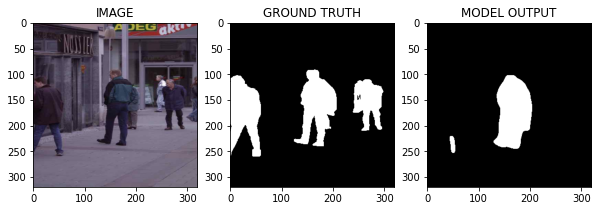

In [108]:
idx =20

model.load_state_dict(torch.load('/content/best_valid_loss_model.pt'))
image, mask = validset[idx]

image_tensor = image.to(DEVICE).unsqueeze(0)
logits_mask = model(image_tensor)  
logits_mask = torch.sigmoid(logits_mask)
logits_mask = (logits_mask>0.5)*1.0
helper.show_image(image,mask,logits_mask.detach().cpu().squeeze(0))

# For updates about upcoming and current guided projects follow me on...

Twitter : @parth_AI

Linkedin : www.linkedin.com/in/pdhameliya